In [1]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn as sns
%matplotlib inline

In [2]:
#connection to database
conn = pyodbc.connect('DRIVER={SQL Server}; SERVER=195.251.232.96; Database=cosmote; UID=asimakistav; PWD=dgc*uyu@grp@ZYU6ayr;')
cursor = conn.cursor()
conn.commit()
sql_query = pd.read_sql_query("""SELECT * FROM renewal_hashed""", conn, parse_dates=['PERIOD_SK'])
df = pd.DataFrame(sql_query)
#df.head()

In [4]:
#create copy of original datafarame
df_original = df.copy()

In [5]:
#shape
df_original.shape

(65692, 155)

In [139]:
df_original.loc[(df_original['FLAG_RENEWAL'] == 1) & (df_original['REN_CHANNEL'] != 'App/Portal'),  'FLAG_RENEWAL'] = 0
target = 'FLAG_RENEWAL'
y = df_original[target]
leakage_columns = ["HASH_CK","PERIOD_SK","LAST_RENEWAL_DATE","FLAG_RENEWAL_DATE",
                   "FLAG_CREDIT_FLAG","FLAG_REN_CHANNEL","REN_CHANNEL","FLAG_REN_COMMITMENT_AMOUNT",target]

drop_cols = leakage_columns
data = df_original.drop(drop_cols, axis=1)
data.head()

,LAST_CREDIT_FLAG,LAST_REN_COMMITMENT_AMOUNT,PREV_CREDIT_FLAG,CUR_POST_ONNET,CUR_POST_ON_FIXED,CUR_POST_OFFNET,CUR_POST_OFF_FIXED,CUR_POST_REST,PREV_POST_ONNET,PREV_POST_ON_FIXED,...,APP_F2R_PRE,APP_STORES_PRE,APP_HH_PRE,APP_TV_PRE,APP_RENEWAL_FIXED_PRE,APP_RENEWAL_PRE,APP_RATE_PLAN_CHANGE_PRE,APP_RENEWALS_FIXED_PRE2,APP_RENEWAL_PRE2,REN_RATE_PLAN
0,None,NaN,None,NaN,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,N,159.0052,N,8157.0,NaN,1144.0,184.0,NaN,23538.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSMOTE GIGAMAX 1GB M
2,Y,720.0000,Y,44502.0,NaN,36660.0,6523.0,27.0,140519.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSMOTE GIGAMAX UNLIMITED
3,N,300.0000,N,3615.0,NaN,77.0,117.0,NaN,11780.0,NaN,...,NaN,5.0,NaN,NaN,16.0,NaN,NaN,23.0,NaN,None
4,Y,96.0000,N,11278.0,NaN,7266.0,2190.0,NaN,49691.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSMOTE GIGAMAX Family M


C:\Users\stavr\Anaconda3\envs\test\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


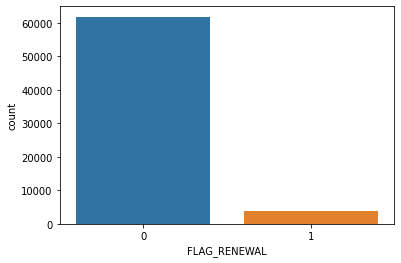

In [6]:
ax = sns.countplot(y, label = 'Count')

# Correlations of Numeric Data

In [140]:
numeric_features = data.select_dtypes('number').columns
data_numeric = pd.DataFrame(data[numeric_features], columns=numeric_features)

In [141]:
data_numeric.shape

(65692, 121)

## Null values and Imputations

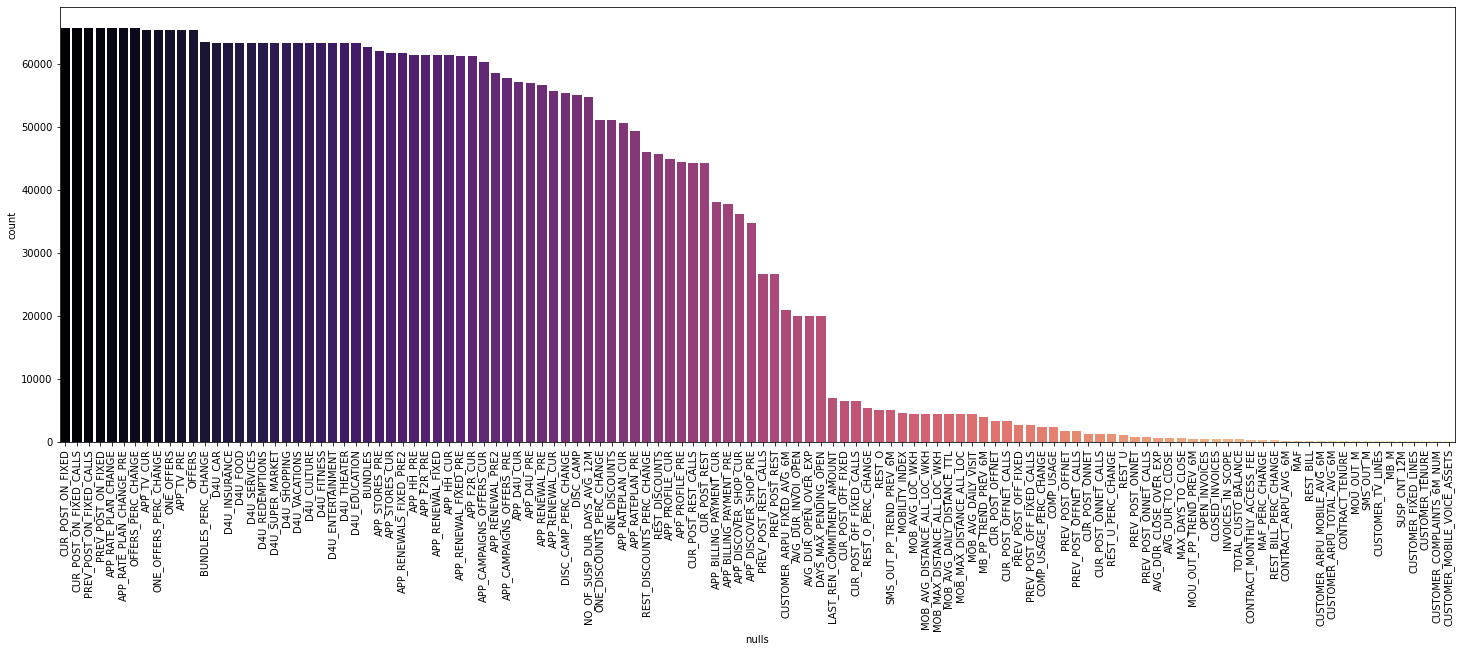

In [11]:
import itertools
data = pd.DataFrame({'nulls': list(itertools.chain(*[[row['index']] * row['nulls'] for idx, row in data_numeric.isnull().sum().to_frame('nulls').reset_index().iterrows()]))})
plt.subplots(figsize=(25,8))
sns.countplot(x = 'nulls', data = data, order = data['nulls'].value_counts().index, palette='magma')
plt.xticks(rotation=90)
plt.show()

### Relpacements of null values

#### GROUP: POSTPAID PAYMENTS

In [142]:
#1.Drop customers with INVOICES_IN_SCOPE = NULL, drops 409 rows
data_numeric = data_numeric[data_numeric['INVOICES_IN_SCOPE'].notna()]

#2. Fill with zeros 'DAYS_MAX_PENDING_OPEN', 'AVG_DUR_INVOI_OPEN','AVG_DUR_OPEN_OVER_EXP' if OPEN_INVOICES=0 (=~ 19000 rows)
mask_1 = (data_numeric['OPEN_INVOICES'] == 0) & (data_numeric['DAYS_MAX_PENDING_OPEN'].isnull())
data_numeric['DAYS_MAX_PENDING_OPEN'][mask_1] = 0
mask_2 = (data_numeric['OPEN_INVOICES'] == 0) & (data_numeric['AVG_DUR_INVOI_OPEN'].isnull())
data_numeric['AVG_DUR_INVOI_OPEN'][mask_2] = 0
mask_3 = (data_numeric['OPEN_INVOICES'] == 0) & (data_numeric['AVG_DUR_OPEN_OVER_EXP'].isnull())
data_numeric['AVG_DUR_OPEN_OVER_EXP'][mask_3] = 0
mask_4 = data_numeric['AVG_DUR_CLOSE_OVER_EXP'].isnull()
data_numeric.loc[mask_4, 'AVG_DUR_CLOSE_OVER_EXP'] = 0

# 3. MAX_DAYS_TO_CLOSE= NULL AND AVG_DUR_TO_CLOSE = NULL ---> REPLACE 296 ROWS WITH MEAN VALUE
data_numeric['MAX_DAYS_TO_CLOSE'].fillna(data_numeric['MAX_DAYS_TO_CLOSE'].mean(), inplace=True)
data_numeric['AVG_DUR_TO_CLOSE'].fillna(data_numeric['AVG_DUR_TO_CLOSE'].mean(), inplace=True)

data_numeric.shape

(65283, 121)

#### GROUP: POSTPAID CHARGES

In [159]:
# Replace NULL values with zeros
cols = ['COMP_USAGE', 'COMP_USAGE_PERC_CHANGE',
       'REST_U', 'REST_U_PERC_CHANGE', 'ONE_OFFERS', 'ONE_OFFERS_PERC_CHANGE',
       'BUNDLES', 'BUNDLES_PERC_CHANGE', 'OFFERS', 'OFFERS_PERC_CHANGE',
       'REST_O', 'REST_O_PERC_CHANGE', 'ONE_DISCOUNTS',
       'ONE_DISCOUNTS_PERC_CHANGE', 'DISC_CAMP', 'DISC_CAMP_PERC_CHANGE',
       'REST_DISCOUNTS', 'REST_DISCOUNTS_PERC_CHANGE', 'MAF',
       'MAF_PERC_CHANGE', 'REST_BILL', 'REST_BILL_PERC_CHANGE']

#data_numeric.loc[:,cols].fillna(0, inplace=True) 
# the above did not work I dont know why

for col in cols:
    data_numeric[col].fillna(0, inplace=True)


#### GROUP: DEMOGRAPHICS AND REST

In [169]:
#1. Delete rows with CONTRACT/CUSTOMER TENURE = NULL (3 same rows)
data_numeric = data_numeric[data_numeric['CONTRACT_TENURE'].notna()]

#2. Delete rows with 'CONTRACT_MONTHLY_ACCESS_FEE'=NULL (75 rows)
data_numeric = data_numeric[data_numeric['CONTRACT_MONTHLY_ACCESS_FEE'].notna()]

#3. Replace NULLS of rest of the numeric attributes with 0 except MOBILITY INDEX--> (mean?)
cols_2 = ['MOU_OUT_M', 'MOU_OUT_PP_TREND_PREV_6M', 'SMS_OUT_M',
       'SMS_OUT_PP_TREND_PREV_6M', 'MB_M', 'MB_PP_TREND_PREV_6M',
       'NO_OF_SUSP_DUR_DAYS_AVG_12M', 'SUSP_CNT_12M', 'CONTRACT_ARPU_AVG_6M',
       'CUSTOMER_COMPLAINTS_6M_NUM', 'CUSTOMER_ARPU_TOTAL_AVG_6M',
       'CUSTOMER_ARPU_FIXED_AVG_6M', 'CUSTOMER_ARPU_MOBILE_AVG_6M',
       'CUSTOMER_MOBILE_VOICE_ASSETS', 'CUSTOMER_FIXED_LINES',
       'CUSTOMER_TV_LINES']

for col in cols_2:
    mask = (data_numeric[col].isnull())
    data_numeric.loc[mask,col] = 0
    
#4. MOBILITY INDEX nulls are replaced with mean value
data_numeric['MOBILITY_INDEX'].fillna(data_numeric['MOBILITY_INDEX'].mean(), inplace=True)

#### APP EVENTS AND D4U

In [202]:
# 'D4U_THEATER', 'D4U_FITNESS', 'D4U_CULTURE','D4U_ENTERTAINMENT','D4U_SERVICES','D4U_INSURANCE' consist 100% of NULLS
drop_cols_d4u = ['D4U_THEATER', 'D4U_FITNESS', 'D4U_CULTURE','D4U_ENTERTAINMENT','D4U_SERVICES','D4U_INSURANCE'
                 ,'D4U_EDUCATION']
data_numeric.drop(drop_cols_d4u, axis=1, inplace=True)

# Replace NULL of all other d4u numeric attributes with 0
cols_d4u = ['D4U_FLAG', 'D4U_REDEMPTIONS', 'D4U_SUPER_MARKET',
        'D4U_SHOPPING', 'D4U_VACATIONS', 'D4U_CAR',
        'D4U_FOOD']

for col in cols_d4u:
    mask_d4u = (data_numeric[col].isnull())
    data_numeric.loc[mask_d4u,col] = 0

#APP EVENTS: replace all NULL values with 0
cols_app = ['APP_DISCOVER_SHOP_CUR',
       'APP_BILLING_PAYMENT_CUR', 'APP_RATEPLAN_CUR', 'APP_PROFILE_CUR',
       'APP_CAMPAIGNS_OFFERS_CUR', 'APP_D4U_CUR', 'APP_F2R_CUR',
       'APP_STORES_CUR', 'APP_HH_CUR', 'APP_TV_CUR', 'APP_RENEWAL_FIXED',
       'APP_RENEWAL_CUR', 'APP_RATE_PLAN_CHANGE', 'APP_DISCOVER_SHOP_PRE',
       'APP_BILLING_PAYMENT_PRE', 'APP_RATEPLAN_PRE', 'APP_PROFILE_PRE',
       'APP_CAMPAIGNS_OFFERS_PRE', 'APP_D4U_PRE', 'APP_F2R_PRE',
       'APP_STORES_PRE', 'APP_HH_PRE', 'APP_TV_PRE', 'APP_RENEWAL_FIXED_PRE',
       'APP_RENEWAL_PRE', 'APP_RATE_PLAN_CHANGE_PRE',
       'APP_RENEWALS_FIXED_PRE2', 'APP_RENEWAL_PRE2']


for col in cols_app:
    mask_app = (data_numeric[col].isnull())
    data_numeric.loc[mask_app,col] = 0

#### POSTPAID USAGE

In [222]:
#1. Drop columns'CUR_POST_ON_FIXED', 'CUR_POST_ON_FIXED_CALLS', 'PREV_POST_ON_FIXED', 'PREV_POST_ON_FIXED_CALLS'=~ 100% NULL
drop_cols_usage = ['CUR_POST_ON_FIXED', 'CUR_POST_ON_FIXED_CALLS', 
                   'PREV_POST_ON_FIXED', 'PREV_POST_ON_FIXED_CALLS']

data_numeric.drop(drop_cols_usage, axis=1, inplace=True)

#Replace NULL of all other numeric attributes with 0
cols_usage = ['CUR_POST_ONNET', 'CUR_POST_OFFNET',
       'CUR_POST_OFF_FIXED', 'CUR_POST_REST', 'PREV_POST_ONNET',
       'PREV_POST_OFFNET', 'PREV_POST_OFF_FIXED', 'PREV_POST_REST',
       'CUR_POST_ONNET_CALLS', 'CUR_POST_OFFNET_CALLS',
       'CUR_POST_OFF_FIXED_CALLS', 'CUR_POST_REST_CALLS',
       'PREV_POST_ONNET_CALLS', 'PREV_POST_OFFNET_CALLS',
       'PREV_POST_OFF_FIXED_CALLS', 'PREV_POST_REST_CALLS']

for col in cols_usage:
    mask_usage = (data_numeric[col].isnull())
    data_numeric.loc[mask_usage,col] = 0

#### MOBILITY

In [242]:
# Cosmote suggests we keep it null. Try imputation with the mean value

cols_mob = ['MOB_MAX_DISTANCE_ALL_LOC',
       'MOB_AVG_DAILY_DISTANCE_TTL', 'MOB_AVG_DAILY_VISIT',
       'MOB_MAX_DISTANCE_ALL_LOC_WKH', 'MOB_AVG_DISTANCE_ALL_LOC_WKH',
       'MOB_AVG_LOC_WKH']

for col in cols_mob:
    mask_mob = (data_numeric[col].isnull())
    data_numeric.loc[mask_mob,col] = data_numeric[col].mean()

In [261]:
data_numeric.isnull().sum().value_counts()

0       109
6702      1
dtype: int64

## Pairs of correlated features 

In [259]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    abs_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    abs_corr = abs_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return abs_corr

print("Top Absolute Correlations")
print(get_top_abs_correlations(data_numeric)[60:120])


Top Absolute Correlations
APP_RATEPLAN_PRE              APP_RENEWAL_PRE                 0.743885
CUR_POST_OFFNET               CUR_POST_OFFNET_CALLS           0.742943
APP_BILLING_PAYMENT_CUR       APP_RENEWAL_FIXED_PRE           0.735351
MOB_MAX_DISTANCE_ALL_LOC      MOB_AVG_DAILY_DISTANCE_TTL      0.734861
CUR_POST_ONNET_CALLS          MOU_OUT_M                       0.729932
MOB_MAX_DISTANCE_ALL_LOC_WKH  MOB_AVG_DISTANCE_ALL_LOC_WKH    0.729532
APP_RATEPLAN_CUR              APP_RENEWAL_PRE                 0.722851
LAST_REN_COMMITMENT_AMOUNT    CONTRACT_MONTHLY_ACCESS_FEE     0.722265
APP_RENEWAL_FIXED             APP_BILLING_PAYMENT_PRE         0.721670
APP_BILLING_PAYMENT_CUR       APP_RENEWAL_CUR                 0.719429
PREV_POST_ONNET               PREV_POST_ONNET_CALLS           0.718308
OPEN_INVOICES                 DAYS_MAX_PENDING_OPEN           0.711200
APP_DISCOVER_SHOP_PRE         APP_BILLING_PAYMENT_PRE         0.709846
CUR_POST_OFFNET               MOU_OUT_M            

<AxesSubplot:>

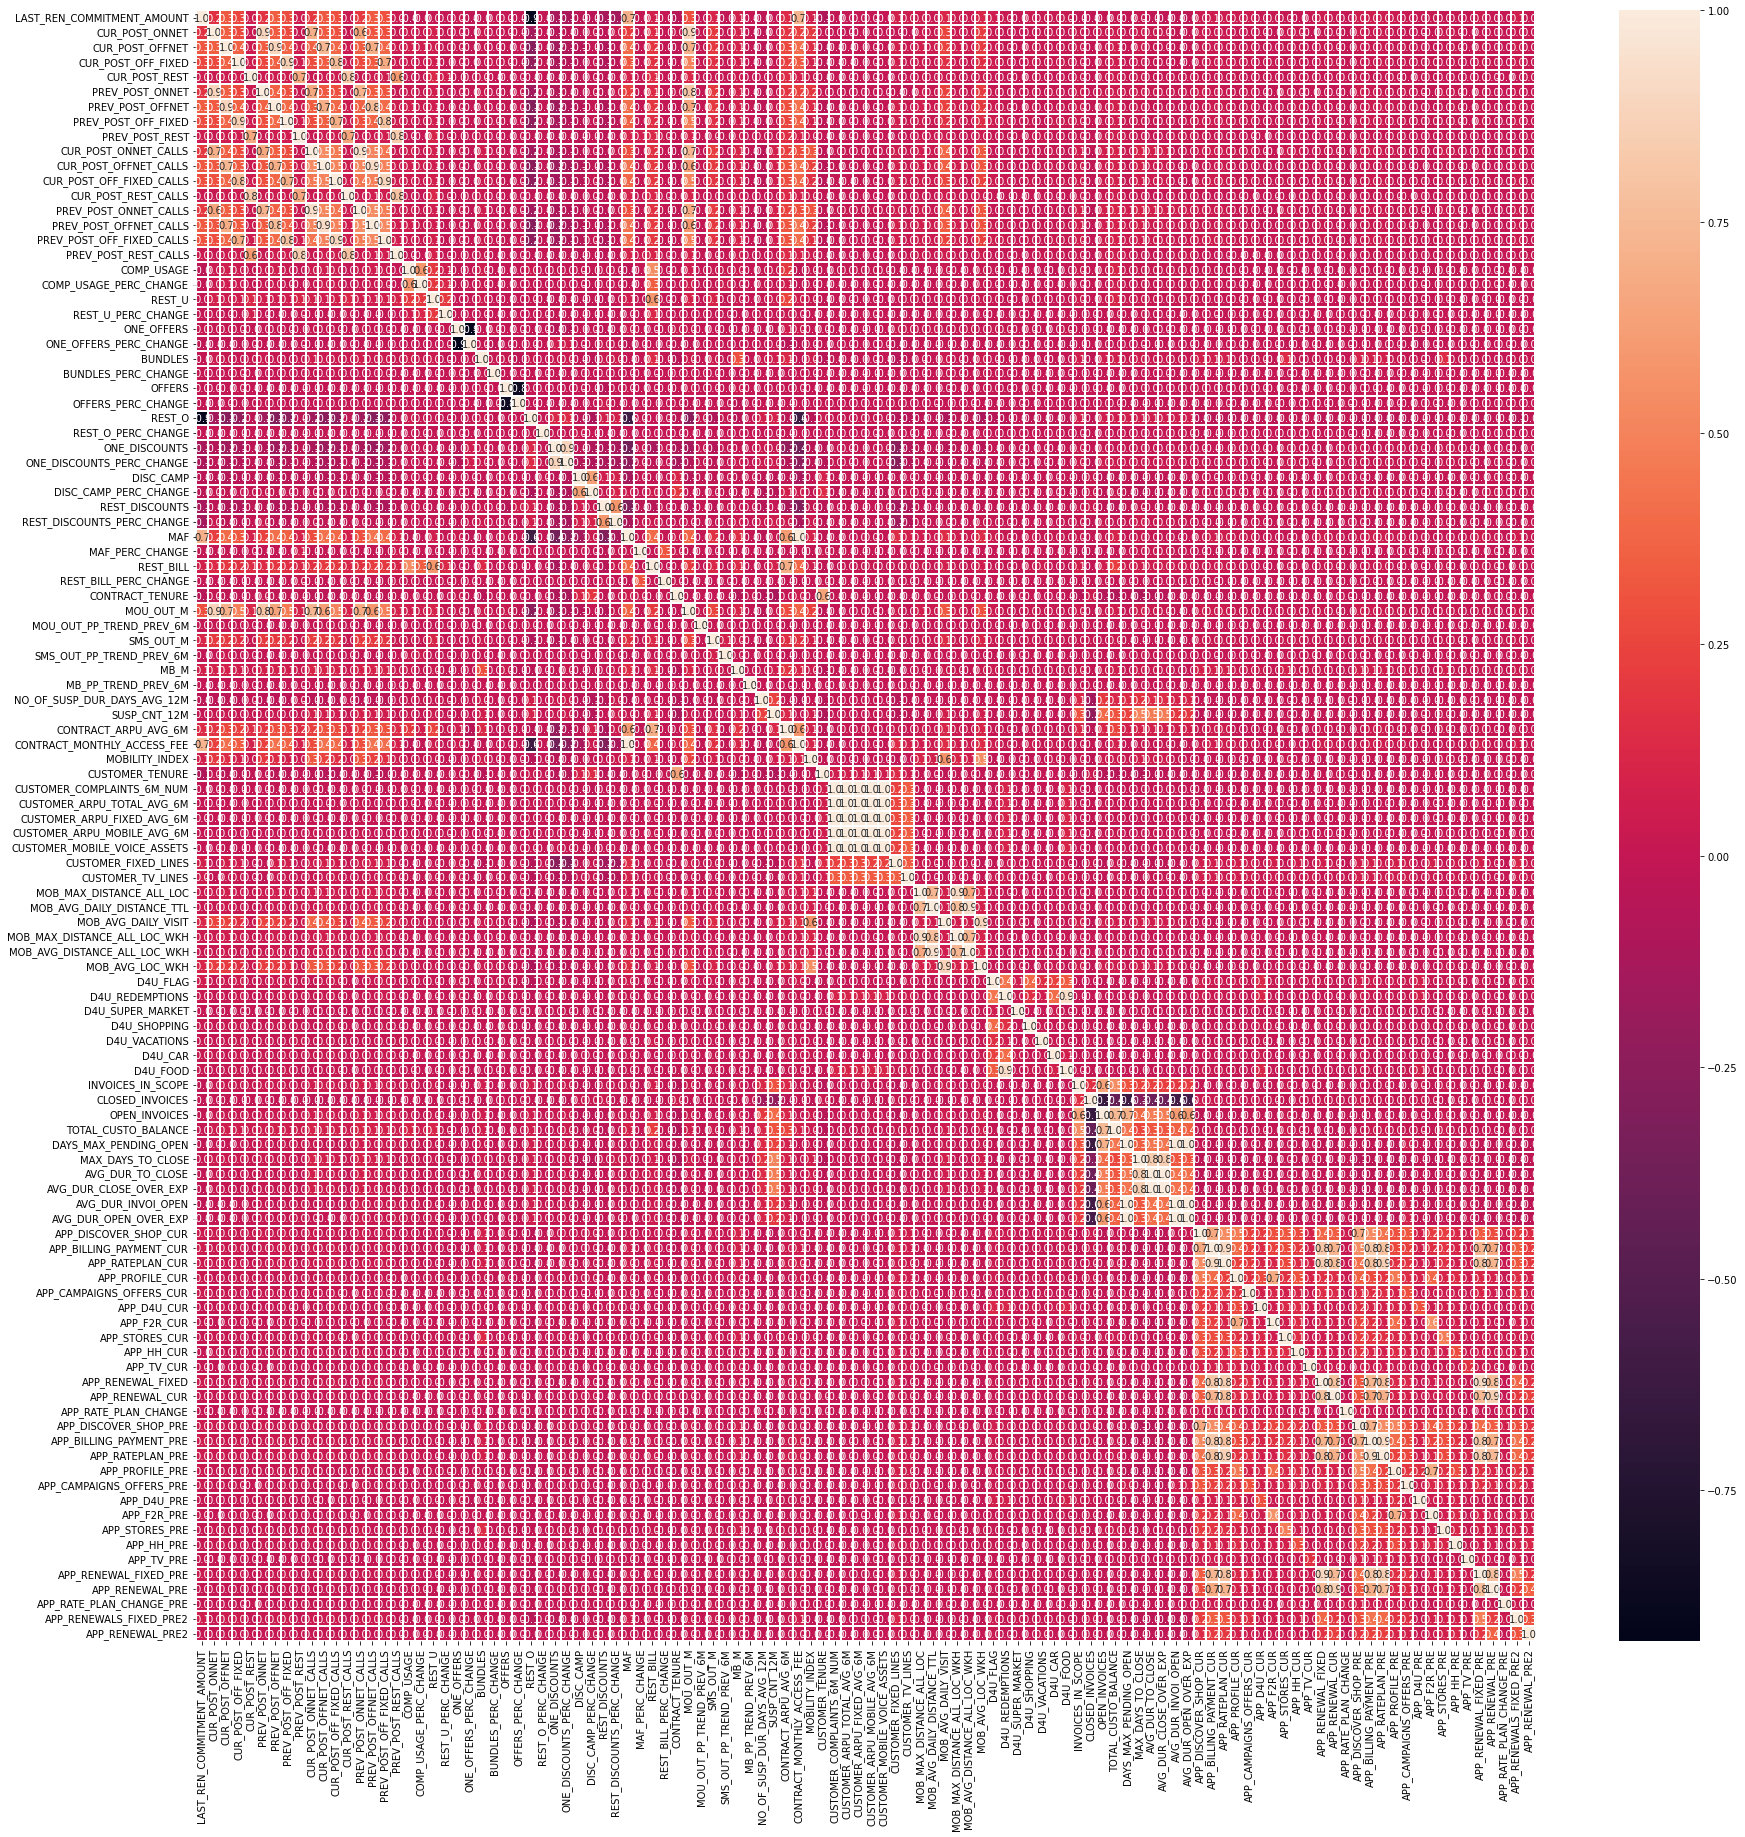

In [255]:
f, ax = plt.subplots(figsize= (30,30))
sns.heatmap(data_numeric.corr(), annot=True, linewidths=.4, fmt='.1f', ax=ax)

In [262]:
pwd

'C:\\WINDOWS\\system32'